In [80]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math
from collections import deque
import random

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-

In [3]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle','Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()
        
#     def agents_state_find(self, scene, output_array, target_agent_type_list):
        
#         frame_interval = .dataset.scenes[scene]['frame_index_interval']
        
#         cars_list = target_agent_type_list[0]
#         pedestrian_list = target_agent_type_list[1]
        
#         for agent_list in target_agent_type_list:
#             for agent in agent_list:
#                     agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
#                     if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
#                         for frame in frames

#                     elif idx== self.label_dict[target_label]-3:
#                         plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

In [4]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

# Find the entire turning scene at lane_merge 

In [13]:
Test.dataset.scenes[0][0][1]

248

In [16]:
Test.frames[248]['ego_translation'][:2]

array([  908.60375977, -1507.56835938])

In [30]:
lane_merge_full = []

for idx, scene in tqdm(enumerate(Test.dataset.scenes[:])):
    
    begin_location = Test.frames[scene[0][0]]['ego_translation'][:2]
    end_location = Test.frames[scene[0][1]-1]['ego_translation'][:2]
    
    if end_location[1] > 1440 and begin_location[1] < 1415:
        
        lane_merge_full.append(idx)

134622it [02:51, 782.76it/s]


In [37]:
lane_merge_full

[581,
 782,
 839,
 950,
 1005,
 1064,
 1266,
 1301,
 1324,
 1449,
 1605,
 1634,
 1783,
 1833,
 1994,
 2069,
 2359,
 2695,
 2756,
 2802,
 2918,
 3038,
 3097,
 3282,
 3338,
 3586,
 3743,
 3797,
 4958,
 5047,
 5333,
 5392,
 5447,
 5502,
 5556,
 5603,
 5650,
 5707,
 5930,
 6039,
 6179,
 6667,
 6760,
 6865,
 6926,
 6997,
 7120,
 7175,
 7381,
 7576,
 7891,
 7946,
 8049,
 8147,
 8246,
 8350,
 8913,
 8978,
 9087,
 9138,
 9323,
 9381,
 10970,
 11120,
 11131,
 11202,
 11258,
 11368,
 11497,
 11559,
 11665,
 11718,
 11835,
 11881,
 11936,
 12001,
 12065,
 12311,
 12516,
 12574,
 12634,
 12741,
 13147,
 13417,
 13468,
 13737,
 13786,
 13985,
 14040,
 14150,
 14442,
 14550,
 14598,
 14756,
 14905,
 14965,
 15174,
 15266,
 15694,
 15978,
 16382,
 19540,
 20090,
 20144,
 20193,
 20247,
 20297,
 20403,
 20466,
 20527,
 20667,
 21049,
 21112,
 21504,
 21561,
 21798,
 22002,
 22123,
 22252,
 22441,
 22701,
 22757,
 23007,
 23070,
 23348,
 23417,
 23609,
 23666,
 23885,
 23938,
 23995,
 24052,
 24153,
 2

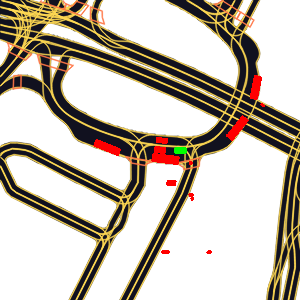

In [49]:
Test.scene_visualize(581, ego_dataset, cfg)

In [39]:
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

grid_boundary={}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [54]:
def extract_trajectory_in_scene(scene, Test, zarr_dataset, intersection_id, grid_boundary):
    """
    get downsampled trajectory in a scene
    return: ego, veh, ped, cyc trajectories
    """
    frame_interval = zarr_dataset.scenes[scene]['frame_index_interval']
    length = frame_interval[1] - frame_interval[0]
#     print(length)
    
    if length<245:
        return [], [], []


    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])

    # filter the agents
    car_id_list = []
    for car_id in Test.agent_list[0]:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==car_id)[0]]
        if agent_loc.shape[0] > 100 and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
            car_id_list.append(car_id)
#     print("caridlist",car_id_list)
    
    pedestrian_id_list = []
    for pedestrian_id in Test.agent_list[-1]:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==pedestrian_id)[0]]
        if agent_loc.shape[0] > 100:  # more than 20 sec
            pedestrian_id_list.append(pedestrian_id)
#     print("pedidlist",pedestrian_id_list)
    cyc_id_list = []
    clist=[]
    for c in Test.agent_list[-3]:
        clist.append(c)
    for c in Test.agent_list[-5]:
        clist.append(c)
    for cyc_id in clist:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==cyc_id)[0]]
        if agent_loc.shape[0] > 100:  # more than 10 sec
            cyc_id_list.append(cyc_id)
#     print("cycidlist",cyc_id_list)
      

    sampling_id=range(0, 240,5)
    
    all_veh_traj=[]
    all_ped_traj=[]
    all_cyc_traj=[]
    
    
    for car_idx, car_id in enumerate(car_id_list):
        temp_traj=[]
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if car_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==car_id)[0]]['centroid'][0]
                temp_traj.append(loc)
            if len(temp_traj)==20: # if a long trajectory is longer than 10s, we treat the rest as trajectory from other agent
                all_veh_traj.append(temp_traj)
                temp_traj=[]
              
         
    for ped_idx, ped_id in enumerate(pedestrian_id_list):
        temp_traj=[]
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if ped_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==ped_id)[0]]['centroid'][0]
                temp_traj.append(loc)
            if len(temp_traj)==20:
                all_ped_traj.append(temp_traj)
                temp_traj=[]

    for cyc_idx, cyc_id in enumerate(cyc_id_list):
        temp_traj=[]
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if cyc_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==cyc_id)[0]]['centroid'][0]
                temp_traj.append(loc)
            if len(temp_traj)==20:
                all_cyc_traj.append(temp_traj)
                temp_traj=[]
    return np.array(all_veh_traj), np.array(all_ped_traj), np.array(all_cyc_traj)

In [56]:
# run an example
all_veh_traj, all_ped_traj, all_cyc_traj = extract_trajectory_in_scene(581, Test, zarr_dataset, 'lane_merge', grid_boundary=grid_boundary) # 2148, 5532
print(all_veh_traj.shape)
print(all_ped_traj.shape)
print(all_cyc_traj.shape)

(2, 20, 2)
(1, 20, 2)
(0,)


In [61]:
lane_merge_valid_full = []

for scene in tqdm(lane_merge_full):
    
    result = Test.agent_trajectory(scene, 'Pedestrian', junction_boundary['lane_merge'])
    
    if len(result) >0:
        lane_merge_valid_full.append(scene)
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 778/778 [00:19<00:00, 39.15it/s]


In [67]:
def get_allscenes_intersection(junction_scenes=lane_merge_valid_full):
    final_veh, final_ped, final_cyc=None, None, None
    all_scene_dict={}
    for _, scene in enumerate(junction_scenes):
        scene_dict={'veh':[], 'ped':[], 'cyc':[]}
        print("i-th, scene", _, scene)
        all_veh_traj, all_ped_traj, all_cyc_traj = extract_trajectory_in_scene(scene, Test, zarr_dataset, '8KfB', grid_boundary=grid_boundary) # 3134

        if len(all_veh_traj)>0:
            scene_dict['veh']=all_veh_traj
            if final_veh is None:
                final_veh = all_veh_traj
            else:
                final_veh = np.vstack((final_veh, all_veh_traj))

        if len(all_ped_traj)>0:
            scene_dict['ped']=all_ped_traj
            if final_ped is None:
                final_ped = all_ped_traj
            else:
                final_ped = np.vstack((final_ped, all_ped_traj))

        if len(all_cyc_traj)>0:
            scene_dict['cyc']=all_cyc_traj
            if final_cyc is None:
                final_cyc = all_cyc_traj
            else:
                final_cyc = np.vstack((final_cyc, all_cyc_traj))
        all_scene_dict[_]=scene_dict
    #     if _>3:
    #         break
    np.save("lane_merge_alltraj_veh", final_veh)
    np.save("lane_merge_alltraj_ped", final_ped)
    np.save("lane_merge_alltraj_cyc", final_cyc)
    print('saved')
    
    return final_veh, final_ped, final_cyc, all_scene_dict

In [134]:
final_veh, final_ped, final_cyc, all_scene_dict = get_allscenes_intersection()
print(final_veh.shape, final_ped.shape, final_cyc.shape)

i-th, scene 0 581
i-th, scene 1 782
i-th, scene 2 839
i-th, scene 3 950
i-th, scene 4 1005
i-th, scene 5 1064
i-th, scene 6 1266
i-th, scene 7 1301
i-th, scene 8 1324
i-th, scene 9 1449
i-th, scene 10 1605
i-th, scene 11 1634
i-th, scene 12 1783
i-th, scene 13 1833
i-th, scene 14 1994
i-th, scene 15 2069
i-th, scene 16 2359
i-th, scene 17 2695
i-th, scene 18 2756
i-th, scene 19 2802
i-th, scene 20 2918
i-th, scene 21 3038
i-th, scene 22 3097
i-th, scene 23 3282
i-th, scene 24 3338
i-th, scene 25 3586
i-th, scene 26 3743
i-th, scene 27 3797
i-th, scene 28 4958
i-th, scene 29 5047
i-th, scene 30 5333
i-th, scene 31 5392
i-th, scene 32 5447
i-th, scene 33 5502
i-th, scene 34 5556
i-th, scene 35 5603
i-th, scene 36 5650
i-th, scene 37 5707
i-th, scene 38 5930
i-th, scene 39 6039
i-th, scene 40 6179
i-th, scene 41 6667
i-th, scene 42 6760
i-th, scene 43 6865
i-th, scene 44 6926
i-th, scene 45 7120
i-th, scene 46 7175
i-th, scene 47 7381
i-th, scene 48 7576
i-th, scene 49 7891
i-th, scene 50

i-th, scene 381 65939
i-th, scene 382 66014
i-th, scene 383 66074
i-th, scene 384 66184
i-th, scene 385 66392
i-th, scene 386 66751
i-th, scene 387 67130
i-th, scene 388 67193
i-th, scene 389 70486
i-th, scene 390 70726
i-th, scene 391 71881
i-th, scene 392 72043
i-th, scene 393 72224
i-th, scene 394 72271
i-th, scene 395 72322
i-th, scene 396 72380
i-th, scene 397 72544
i-th, scene 398 72598
i-th, scene 399 72655
i-th, scene 400 72706
i-th, scene 401 72753
i-th, scene 402 72995
i-th, scene 403 73248
i-th, scene 404 73301
i-th, scene 405 73421
i-th, scene 406 73474
i-th, scene 407 73585
i-th, scene 408 73720
i-th, scene 409 73970
i-th, scene 410 74028
i-th, scene 411 74326
i-th, scene 412 74486
i-th, scene 413 74575
i-th, scene 414 74726
i-th, scene 415 74781
i-th, scene 416 74888
i-th, scene 417 75041
i-th, scene 418 75192
i-th, scene 419 75486
i-th, scene 420 75540
i-th, scene 421 75597
i-th, scene 422 75705
i-th, scene 423 75822
i-th, scene 424 75862
i-th, scene 425 76221
i-th, scen

i-th, scene 745 130925
i-th, scene 746 130989
i-th, scene 747 131050
i-th, scene 748 131111
i-th, scene 749 131238
i-th, scene 750 131349
i-th, scene 751 131700
i-th, scene 752 131862
i-th, scene 753 132066
i-th, scene 754 132177
i-th, scene 755 132403
i-th, scene 756 132458
i-th, scene 757 132508
i-th, scene 758 132568
i-th, scene 759 132707
i-th, scene 760 132769
i-th, scene 761 132980
i-th, scene 762 133151
i-th, scene 763 133309
i-th, scene 764 133454
i-th, scene 765 133513
i-th, scene 766 133746
i-th, scene 767 133801
i-th, scene 768 134135
i-th, scene 769 134192
i-th, scene 770 134280
i-th, scene 771 134327
i-th, scene 772 134386
i-th, scene 773 134507
saved
(3424, 20, 2) (893, 20, 2) (137, 20, 2)


# Generate the test and training dataset

In [135]:
partition_factor = 0.2

def dataset_generation(alltraj, partition_factor = partition_factor):
    
    num = alltraj.shape[0]
    num_test = round(num*partition_factor)
    num_train = num - num_test
    
    shuffled_alltraj = np.random.permutation(alltraj)
    
    test = shuffled_alltraj[:num_test,:,:]
    train_raw = shuffled_alltraj[num_test:,:,:]
    
    train = np.zeros([num_train*10,11,2])
    for idx, traj in enumerate(train_raw):   
        for i in range(10):
            train[idx*10+i,:,:] = traj[i:i+11,:]
        
        
    return test, train        

In [136]:
test_cyc, train_cyc = dataset_generation(final_cyc, partition_factor = partition_factor)
test_ped, train_ped = dataset_generation(final_ped, partition_factor = partition_factor)
test_veh, train_veh = dataset_generation(final_veh, partition_factor = partition_factor)

In [137]:
def coordinate_augmentation(test, train):
    
    test_output = np.zeros([test.shape[0],20,4])
    test_output[:,:,:2] = test
    
    for idx, traj in enumerate(test):
        test_output[idx,:,2:] = traj-traj[0,:]
     
    
    train_output = np.zeros([train.shape[0],11,4])
    train_output[:,:,:2] = train
    
    for idx, traj in enumerate(train):
        train_output[idx,:,2:] = traj-traj[0,:]
        
    train_output = np.random.permutation(train_output)
    
    return test_output, train_output
    

In [138]:
cyc_test_output, cyc_train_output = coordinate_augmentation(test_cyc, train_cyc)
ped_test_output, ped_train_output = coordinate_augmentation(test_ped, train_ped)
veh_test_output, veh_train_output = coordinate_augmentation(test_veh, train_veh)

In [139]:
np.save("cyc_test_set_lane_merge", cyc_test_output)
np.save("cyc_train_set_lane_merge", cyc_train_output)
np.save("ped_test_set_lane_merge", ped_test_output)
np.save("ped_train_set_lane_merge", ped_train_output)
np.save("veh_test_set_lane_merge", veh_test_output)
np.save("veh_train_set_lane_merge", veh_train_output)

# GM+Gibbs

In [143]:
from sklearn.mixture import BayesianGaussianMixture
from tabulate import tabulate

def crop(array, max_n_agent=10, is_cyc=False):
    
    if len(array)>=max_n_agent:
        return np.array(array[:max_n_agent])
    if len(array)<max_n_agent:
        complement = np.zeros(shape=(max_n_agent-len(array), 20, 2))
        if len(array)==0:return complement
        if is_cyc:
            replica = math.ceil(max_n_agent/len(array))
            array=list(array)*replica
            return np.array(array[:max_n_agent])
        array = np.vstack((array, complement))
        return array
    else:
        return array

def _get_models(all_scene_dict):
    """
    1. convert trajectories in a scene into a sample [20, 20, 2]-> [20, 40]
    2. BGM
    3. distribution genetation
    """
    training_veh, training_ped, training_cyc = [], [], []
    for scene, scene_dict in all_scene_dict.items():
        veh, ped, cyc = np.array(scene_dict['veh']), np.array(scene_dict['ped']), np.array(scene_dict['cyc'])
        veh = crop(veh)
        ped = crop(ped)
        cyc = crop(cyc,is_cyc=True)
        

        training_veh.append(veh.flatten())
        training_ped.append(ped.flatten())
        training_cyc.append(cyc.flatten())
    print("...", np.array(training_veh).shape)
    training_veh = np.array(training_veh)
    training_ped = np.array(training_ped)
    training_cyc = np.array(training_cyc)
    
    print("training veh")
    bgm_veh = BayesianGaussianMixture(n_components=3, random_state=10, reg_covar=1e-5, n_init=3).fit(training_veh)
    print("training ped")
    bgm_ped = BayesianGaussianMixture(n_components=3, random_state=20, reg_covar=1e-5, n_init=3).fit(training_ped)
    print("training cyc")
    bgm_cyc = BayesianGaussianMixture(n_components=3, random_state=30, reg_covar=1e10, max_iter=200,n_init=3).fit(training_cyc)
    
    return bgm_veh, bgm_ped, bgm_cyc
    
    
def _get_scene_encodings(all_scene_dict, veh_model, ped_model, cyc_model):
    
    
    scene_encoding=[]
    veh_pool, ped_pool, cyc_pool={}, {}, {}
    for scene, scene_dict in all_scene_dict.items():
        veh, ped, cyc = np.array(scene_dict['veh']), np.array(scene_dict['ped']), np.array(scene_dict['cyc'])
        
        veh_p = crop(veh)
        ped_p = crop(ped)
        cyc_p = crop(cyc,is_cyc=True)
        x = veh_model.predict([veh_p.flatten()])
        y = ped_model.predict([ped_p.flatten()])
        z = cyc_model.predict([cyc_p.flatten()])
        scene_encoding.append([x[0],y[0],z[0]])
        
        if x[0] in veh_pool and len(veh)>0:
            veh_pool[x[0]] = np.vstack((veh_pool[x[0]], veh))
        elif len(veh)>0:
            veh_pool[x[0]]= veh
            
        
        if y[0] in ped_pool and len(ped)>0:
            ped_pool[y[0]] = np.vstack((ped_pool[y[0]], ped))
        elif len(ped)>0:
            ped_pool[y[0]]= ped
            
        if z[0] in cyc_pool and len(cyc)>0:
#             print(cyc_pool[z[0]], "cyc", cyc)
            cyc_pool[z[0]] = np.vstack((cyc_pool[z[0]], cyc))
        elif len(cyc)>0:
            cyc_pool[z[0]]= cyc
        
    return np.array(scene_encoding), veh_pool, ped_pool, cyc_pool

def _get_distribution(encodings):
    """
    compute #p(Y/X), P(Z/X), P(X/Y,Z)
    """
     
    Pxy, Pxz=[],[]
    headers = ["X=0", "X=1", "X=2"]
    
    n=len(encodings)
    for x  in range(3):
        idx = np.where(encodings[:,0]==x)
        arr = encodings[idx]
#         print('-',len(arr))
        pxy=[]
        for y in range(3):
            p_arr_idx = np.where(arr[:,1]==y)
            p_arr = arr[p_arr_idx]
#             print('--', len(p_arr))
            p = len(p_arr)/n
            pxy.append(p)
        Pxy.append(pxy)

        pxz=[]
        for z in range(3):
            c_arr_idx = np.where(arr[:,2]==z)
            c_arr = arr[c_arr_idx]
            p = len(c_arr)/n
            pxz.append(p)
        Pxz.append(pxz)
    print(np.array(Pxy), np.sum(Pxy))
    
    Pyzx=[]
    
    for pi in range(3):
        pp=[]
        arr_idx= np.where(encodings[:,1]==pi)
        pi_arr=encodings[arr_idx]
        for zi in range(3):
            pz=[]
            if len(pi_arr)==0:
                pz.append(0)
            else:    
                zarr_idx = np.where(pi_arr[:,2]==zi)
                if len(arr_idx)==0:
                    pz.append(0)
                else:
                    zi_arr = pi_arr[zarr_idx]
                    for xi in range(3):
                        xarr_idx= np.where(zi_arr[:,0]==xi)
                        xi_arr=zi_arr[xarr_idx]
                        pz.append(len(xi_arr)/n)
            pp.append(pz)
        Pyzx.append(pp)
    print(Pyzx, np.sum(Pyzx))
    m = np.array([['X=0'], ['X=1'], ['X=2']])
    headers = ["Y=0", "Y=1", "Y=2"]
    table_value = np.hstack((m, Pxy))
    table = tabulate(table_value, headers, tablefmt="fancy_grid")
    print(table)
    
    headers2 = ["Z=0", "Z=1", "Z=2"]
    table_value2 = np.hstack((m, Pxz))
    table2 = tabulate(table_value2, headers2, tablefmt="fancy_grid")
    print(table2)
    
    return np.array(Pxy), np.array(Pxz), np.array(Pyzx)


In [144]:
veh_model, ped_model, cyc_model = _get_models(all_scene_dict = all_scene_dict)

... (774, 400)
training veh
training ped
training cyc


D:\Anaconda\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [147]:
pickle.dump(veh_model, open("veh_model.pkl", 'wb'))
pickle.dump(ped_model, open("ped_model.pkl", 'wb'))
pickle.dump(cyc_model, open("cyc_model.pkl", 'wb'))

In [158]:
encoding, veh_pool, ped_pool, cyc_pool = _get_scene_encodings(all_scene_dict = all_scene_dict, \
                                                              veh_model=veh_model, ped_model=ped_model, cyc_model=cyc_model)
print(encoding)

[[0 1 2]
 [2 0 2]
 [0 0 2]
 ...
 [0 1 2]
 [0 1 2]
 [0 2 2]]


In [163]:
pickle.dump(veh_pool, open("veh_traj_pool.pkl", 'wb'))
pickle.dump(ped_pool, open("ped_traj_pool.pkl", 'wb'))
pickle.dump(cyc_pool, open("cyc_traj_pool.pkl", 'wb'))

In [164]:
Pxy, Pxz, Pyzx = _get_distribution(encodings=encoding)
print(Pyzx.shape)

[[0.27648579 0.24160207 0.07364341]
 [0.08139535 0.05813953 0.01033592]
 [0.10981912 0.10594315 0.04263566]] 0.9999999999999999
[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.27648578811369506, 0.08139534883720931, 0.10981912144702842]], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.24160206718346253, 0.05813953488372093, 0.10594315245478036]], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.07364341085271318, 0.0103359173126615, 0.04263565891472868]]] 1.0
╒═════╤═══════════╤═══════════╤═══════════╕
│     │       Y=0 │       Y=1 │       Y=2 │
╞═════╪═══════════╪═══════════╪═══════════╡
│ X=0 │ 0.276486  │ 0.241602  │ 0.0736434 │
├─────┼───────────┼───────────┼───────────┤
│ X=1 │ 0.0813953 │ 0.0581395 │ 0.0103359 │
├─────┼───────────┼───────────┼───────────┤
│ X=2 │ 0.109819  │ 0.105943  │ 0.0426357 │
╘═════╧═══════════╧═══════════╧═══════════╛
╒═════╤═══════╤═══════╤══════════╕
│     │   Z=0 │   Z=1 │      Z=2 │
╞═════╪═══════╪═══════╪══════════╡
│ X=0 │     0 │     0 │ 0.591731 │
├─────┼───────┼───────┼──────

In [165]:
pickle.dump(Pxy, open("Pxy_dist.pkl", 'wb'))
pickle.dump(Pxz, open("Pxz_dist.pkl", 'wb'))
pickle.dump(Pyzx, open("Pyzx_dist.pkl", 'wb'))